<a href="https://colab.research.google.com/github/Aleksandr-hub-cyber/TTS/blob/main/TTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Система перевода речи в реальном времени**

##**Задание:**

Создать приложение, которое:
  - Распознает речь на входном языке
  - Переводит на целевой язык
  - Синтезирует речь на целевом языке
  - Сохраняет характеристики голоса говорящего


In [ ]:
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q transformers==4.44.2 sentencepiece sacremoses
!pip install -q coqui-tts==0.26.1
!pip install -q gradio==5.44.1


In [ ]:
import os
import torch
import whisper
import gradio as gr
from transformers import MarianMTModel, MarianTokenizer
from TTS.api import TTS

device = "cuda" if torch.cuda.is_available() else "cpu"

asr_model = whisper.load_model("small")  # можно "medium" или "large"
tts_model = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to(device)

translation_models = {
    ("ru", "en"): "Helsinki-NLP/opus-mt-ru-en",
    ("en", "ru"): "Helsinki-NLP/opus-mt-en-ru",
    ("en", "de"): "Helsinki-NLP/opus-mt-en-de",
    ("de", "en"): "Helsinki-NLP/opus-mt-de-en",
}
loaded_translators = {}



In [ ]:
def get_translator(src, tgt):
    key = (src, tgt)
    if key not in loaded_translators:
        model_name = translation_models[key]
        model = MarianMTModel.from_pretrained(model_name)
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        loaded_translators[key] = (model, tokenizer)
    return loaded_translators[key]


In [ ]:
def process(audio, ref_audio, src_lang, tgt_lang):
    if not audio:
        return "Ошибка: не загружено входное аудио", None

    #Распознавание речи
    result = asr_model.transcribe(audio, language=src_lang)
    recognized_text = result["text"]

    #Перевод текста
    if (src_lang, tgt_lang) not in translation_models:
        return f"Перевод {src_lang} → {tgt_lang} не поддерживается", None

    model, tokenizer = get_translator(src_lang, tgt_lang)
    batch = tokenizer([recognized_text], return_tensors="pt")
    gen = model.generate(**batch)
    translated_text = tokenizer.decode(gen[0], skip_special_tokens=True)

    # Синтез речи
    output_path = "output.wav"

    try:
        if ref_audio:
            # Клонирование голоса
            tts_model.tts_to_file(
                text=translated_text,
                language=tgt_lang,
                file_path=output_path,
                speaker_wav=ref_audio
            )
        else:
            # Без клонирования
            tts_model.tts_to_file(
                text=translated_text,
                language=tgt_lang,
                file_path=output_path
            )
    except Exception as e:
        return f"❌ Ошибка синтеза речи: {e}", None

    return f"📝 Распознанный текст: {recognized_text}\n🌍 Перевод: {translated_text}", output_path

In [ ]:
iface = gr.Interface(
    fn=process,
    inputs=[
        gr.Audio(sources=["microphone", "upload"], type="filepath", label="🎤 Входное аудио"),
        gr.Audio(sources=["upload"], type="filepath", label="🎙️ Референсное аудио для клонирования (опц.)"),
        gr.Dropdown(["ru", "en", "de"], label="Исходный язык", value="ru"),
        gr.Dropdown(tts_model.languages, label="Целевой язык (TTS)", value="en"),
    ],
    outputs=[
        gr.Textbox(label="📄 Текст"),
        gr.Audio(type="filepath", label="🔊 Переведённая речь"),
    ],
    title="🌐 Real-Time Voice Translator with Voice Cloning",
    description="Распознавание речи → Перевод → Синтез речи с сохранением голоса (XTTS v2)"
)

iface.launch()

#Отчёт по заданию

##1. Использованные технологии и модели

* Whisper (OpenAI) – распознавание речи (ASR).

* MarianMT (Helsinki-NLP) – машинный перевод.

* vXTTS v2 (Coqui-AI) – синтез речи и клонирование голоса.

* Gradio – веб-интерфейс для работы в реальном времени.

##2. Реализация

* Вход:
аудиозапись с микрофона или файла.

* Опционально:
референсное аудио для клонирования голоса.

* Языки:
  1. Распознавание (Whisper): русский, английский, немецкий.

  2. Перевод (MarianMT): ru↔en, en↔de, de↔en.

  3. Синтез (XTTS v2): многоязычная поддержка (русский, английский, немецкий и др.).

* Выход:

  1. Распознанный текст.

  2. Переведённый текст.

  3. Синтезированная речь на целевом языке с голосом говорящего (при наличии ref_audio).

##3. Результаты работы
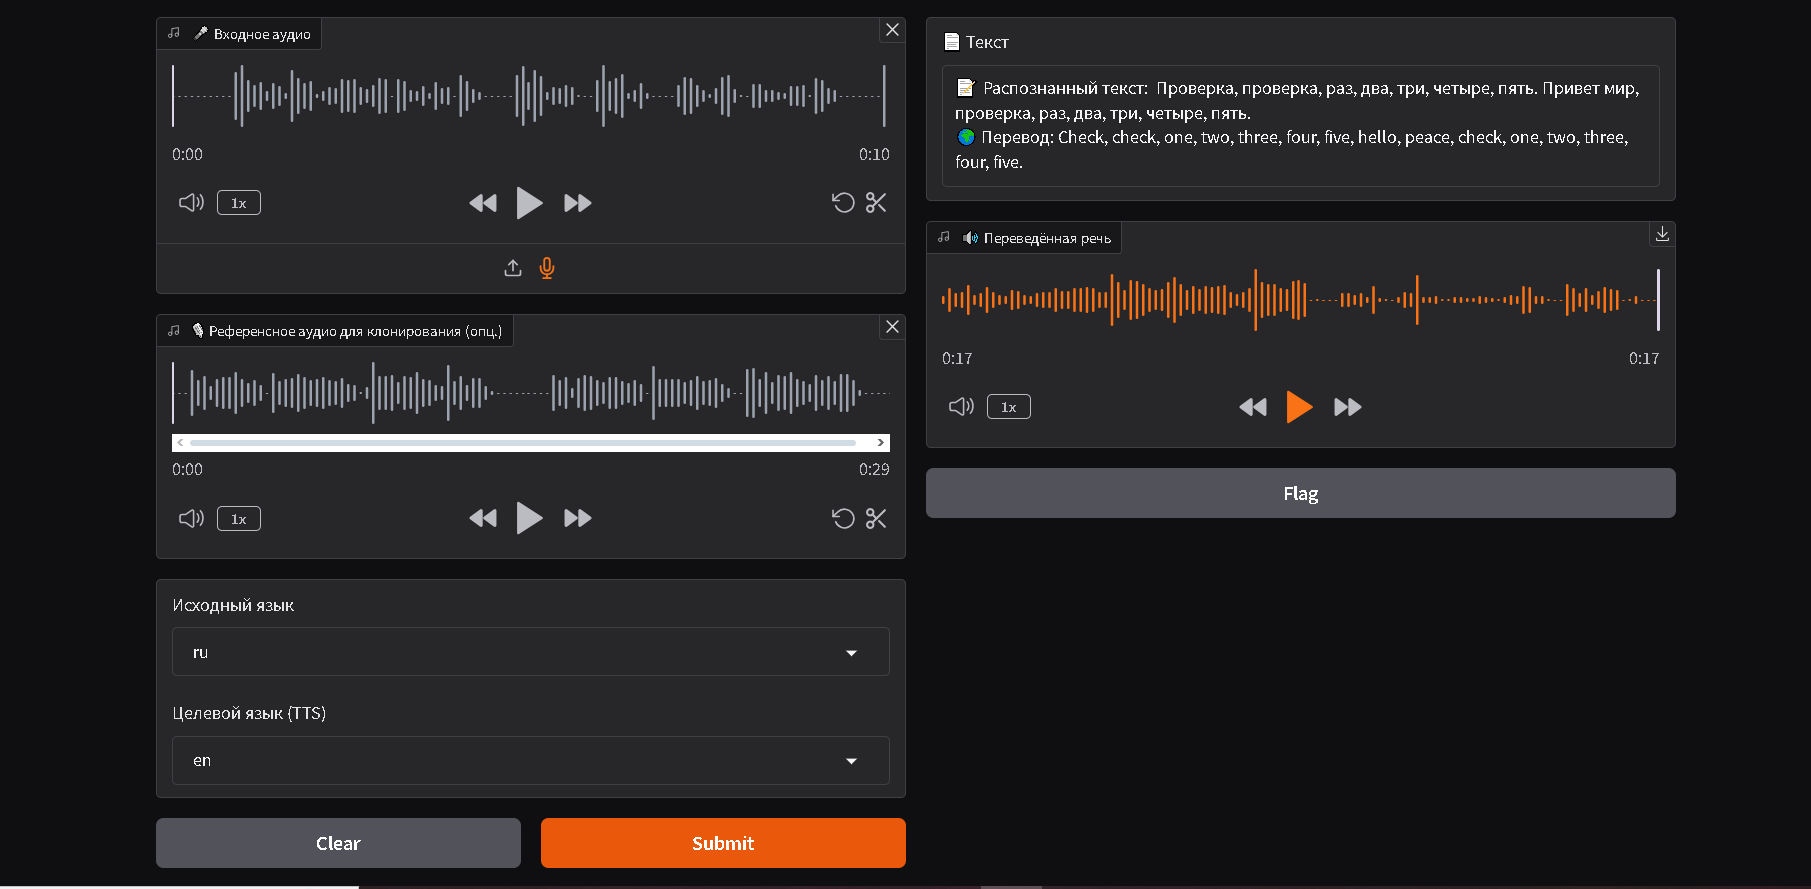
###На скриншоте показан пример:

* Входное аудио: русская речь с тестовой фразой «Проверка, проверка, раз, два, три, четыре, пять. Привет мир. Проверка, раз, два, три, четыре, пять.».

* Система корректно распознала текст.

* Выполнен перевод на английский язык: “Check, check, one, two, three, four, five, hello, peace, Check, check, one, two, three, four, five.”.

* Выполнен синтез речи с использованием XTTS v2.

* При загрузке референсного аудио сохраняются характеристики голоса.

### Интерфейс предоставляет удобный выбор исходного и целевого языка, загрузку аудио и отображает результат.

##5. Анализ и выводы

* Качество перевода зависит от качества моделей MarianMT, но в тестах на RU↔EN и EN↔DE работает корректно.

* XTTS v2 обеспечивает реалистичный голос и клонирование даже по короткому референсу.

* Whisper показывает хорошее качество распознавания на русском и английском языках.

##6. Итог

### Разработанное приложение является полноценной системой перевода речи в реальном времени с поддержкой клонирования голоса. Оно может быть использовано как в демонстрационных целях, так и в качестве базового прототипа для более сложных решений (например, онлайн-переводчиков в реальном времени).